Loading data...
id        0
cat_0     0
cat_1     0
cat_2     0
cat_3     0
cat_4     0
cat_5     0
cat_6     0
cat_7     0
cat_8     0
cat_9     0
cat_10    0
cat_11    0
cat_12    0
cat_13    0
cat_14    0
cat_15    0
cat_16    0
cat_17    0
cat_18    0
cat_19    0
num_0     0
num_1     0
num_2     0
num_3     0
num_4     0
num_5     0
num_6     0
num_7     0
num_8     0
num_9     0
num_10    0
num_11    0
num_12    0
num_13    0
num_14    0
num_15    0
num_16    0
num_17    0
num_18    0
num_19    0
num_20    0
num_21    0
num_22    0
num_23    0
num_24    0
num_25    0
num_26    0
num_27    0
num_28    0
num_29    0
num_30    0
num_31    0
num_32    0
num_33    0
num_34    0
num_35    0
num_36    0
num_37    0
target    0
dtype: int64
Data Loading Time: 4.72 seconds
Preprocessing data...
Data Preprocessing Time: 10.06 seconds
Starting Grid Search...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Info] Number of positive: 6763, number of negative: 505237
[

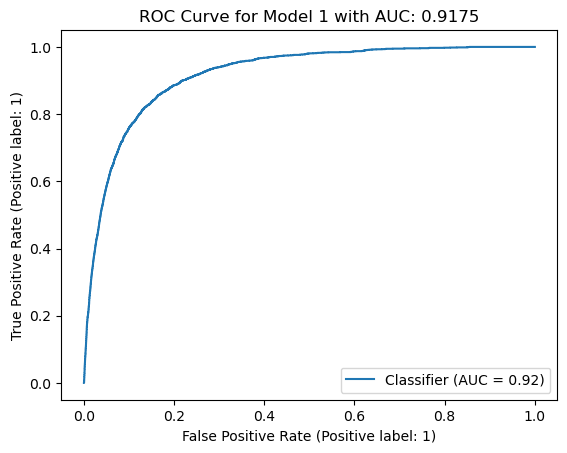

[LightGBM] [Info] Number of positive: 8453, number of negative: 631547
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.208687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9811
[LightGBM] [Info] Number of data points in the train set: 640000, number of used features: 515
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013208 -> initscore=-4.313651
[LightGBM] [Info] Start training from score -4.313651
Model 2 with params {'max_depth': 10, 'n_estimators': 300, 'num_leaves': 60} has ROC AUC: 0.9154, Accuracy: 0.9853
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    157853
         1.0       0.15      0.02      0.04      2147

    accuracy                           0.99    160000
   macro avg       0.57      0.51      0.51    160000
weighted avg       0.98      0

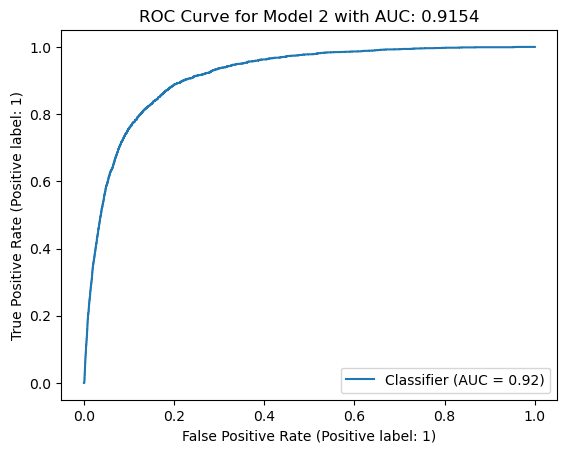

[LightGBM] [Info] Number of positive: 8453, number of negative: 631547
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.204843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9811
[LightGBM] [Info] Number of data points in the train set: 640000, number of used features: 515
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013208 -> initscore=-4.313651
[LightGBM] [Info] Start training from score -4.313651
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Model 3 with params {'max_depth': 10, 'n_estimators': 300, 'num_leaves': 90} has ROC AUC: 0.9186, Accuracy: 0.9861
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    157853
         1.0       0.27      0.02      0.04

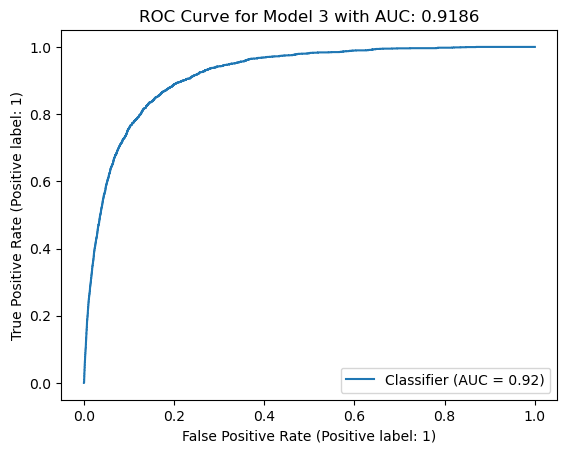

Total Run Time: 889.02 seconds


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, RocCurveDisplay, classification_report, accuracy_score
from lightgbm import LGBMClassifier

# Record start time
start_time = time.time()

print("Loading data...")
# Load dataset
data = pd.read_csv('train.csv')

# Check for missing values
print(data.isnull().sum())

# Record data loading time
data_loading_time = time.time()
print(f'Data Loading Time: {data_loading_time - start_time:.2f} seconds')

print("Preprocessing data...")
# Define categorical and numerical features
cat_features = [f'cat_{i}' for i in range(20)]
num_features = [f'num_{i}' for i in range(38)]

# Data preprocessing pipelines
# For numerical features: impute missing values and scale
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# For categorical features: impute missing values and one-hot encode
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Apply the preprocessing pipelines to the corresponding columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])

# Split the dataset into features and target variable
X = data.drop(['id', 'target'], axis=1)
y = data['target']

# Apply preprocessing to the dataset
X_processed = preprocessor.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Record data preprocessing time
data_preprocessing_time = time.time()
print(f'Data Preprocessing Time: {data_preprocessing_time - data_loading_time:.2f} seconds')

# Define parameter grid for GridSearchCV
params = {
    'max_depth': [10, 15, 20],
    'num_leaves': [30, 60, 90],
    'n_estimators': [100, 200, 300]
}

# Perform parameter tuning using GridSearchCV
print("Starting Grid Search...")
grid_search = GridSearchCV(estimator=LGBMClassifier(), param_grid=params, scoring='roc_auc', cv=5, verbose=1)
grid_search.fit(X_train, y_train)

# Select the top 3 best parameter sets
top_params = sorted(grid_search.cv_results_['mean_test_score'], reverse=True)[:3]
top_models = [grid_search.cv_results_['params'][i] for i in range(len(grid_search.cv_results_['mean_test_score'])) if grid_search.cv_results_['mean_test_score'][i] in top_params]

# Train and evaluate models with the top 3 parameter sets
results = []
for i, params in enumerate(top_models, 1):
    model = LGBMClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]
    y_pred_binary = (y_pred >= 0.5).astype(int)
    roc_auc = roc_auc_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred_binary)
    report = classification_report(y_test, y_pred_binary)
    results.append((params, roc_auc, accuracy, report))
    print(f'Model {i} with params {params} has ROC AUC: {roc_auc:.4f}, Accuracy: {accuracy:.4f}')
    print('Classification Report:')
    print(report)

    # Plot ROC curve
    RocCurveDisplay.from_predictions(y_test, y_pred)
    plt.title(f'ROC Curve for Model {i} with AUC: {roc_auc:.4f}')
    plt.show()

# Record end time and calculate total run time
end_time = time.time()
run_time = end_time - start_time
print(f'Total Run Time: {run_time:.2f} seconds')

